# Assignment 2 - CS110

## 1. Counting Bloom Filters - An Overview

**The problem:**

Let us aim for a data structure that supports the necessary operations to know whether a given element $e$ is in the set $A$. 

**The simplest, but inneficient, solution:**

The simplest way to achieve this would be through the use of a linear vector $v$ that stores each of the elements in $A$. The operation to check whether the element is in the set or not would consist in iterating $v$ and checking each of the positions in the vector. It is trivial that such operation would have a time complexity of $O(n)$.

**How to do a little bit better?**

We may do better if we store the elements in a hash table that allows us to access the elements (and hence check whether they exist or not) in $\Theta(1)$ time. But this would be a waste of space. We would be storing the elements even though we are only interested in checking whether they are in the set $A$ or not.

Instead, it would be more efficient to just record their "existence" in the set. In other words, to use only one bit of information to record either **$(1)$ if $e$ is in $A$**, or **$(0)$ if $e$ is *not* in $A$**. We would certainly start with a hash table filled with zeros, and would switch bits in the aproppriate cells to *one* after building the table (inserting the elements of $A$).

However, under this setting, collisions are devastating. We cannot possibly differentiate whether the $1$ already placed in a given cell corresponds to the existence of the element $e$ that a query is asking for (in addition, traditional approaches to handle collisions in hash tables would not be applicable). 

**How to, actually, do better? - *BLOOM FILTERS***

**We may use, then,** more than one hash function ($h_1,h_2,h_3...$) to place a $1$ in each of the different slots that the set of hash functions being used return for a given element $e$. Then, when querying for an element, it will be *unlikely* that all the slots returned by all the hashes for a given element $e_1$ as input, will be exactly the same one as for another element $e_2$. This is the idea of a ***Bloom Filter***.

One may emphasize on the use of the word *unlikely*. It is still, essentially, possible that two elements point toward the same exact slots. **In addition**, it is also quite (and more) possible that an element $e_1$ points toward slots that interfere with the ones of many other elements (not necessarily only the ones of $e_2$, but also either $e_3, e_4, ..., e_n$). When this happens, the query will equivocally return that the element exist - this is known as a **false positive**. The opposite, **false negatives**, cannot (trivially) occur because if an element was ever inserted, all the corresponding slots would have been switched to one after building the table.

The number of hash functions used is denoted by $k$. Depending on the value of $k$ and the number of elements $m$, the ratio of false positives will be more, or less, optimal.

So, even though we do not get rid entirely of the possibility of false positives, Bloom Filters are certainly a step forward toward making such possibility more unlikely (compared to the possible approach described in the previous section). One may also note that if one actually chooses $k=1$, the Bloom Filter is essentially equivalent to such approach in the previous section (but no one would ever certainly do that, unless we want to ruin the whole purpose of Bloom Filters). 

#### **What about deletions..? - *COUNTING BLOOM FILTERS***

Traditional bloom filters cannot support the removal of items, because if we remove a $1$ (switch the respective bit to $0$) from a slot, it is likely that we will be affecting the slots of many other elements - allowing the possibility of later having several false negatives.

A way to resolve this is through the use of a ***Counting Bloom Filter***. In Counting Bloom Filters, there is a (n-bit) counter on each slot of the table, instead of just a single bit of information for representing either just $1$ or $0$. The counter goes up every time a value is inserted, and down every time a value is removed. For example, if we aim to remove element $e_1$, all counters of all the corresponding slots in the Counting Bloom Filter go down by one. Later, when we do a query for $e_1$, we would expect that it is *likely* that at least one of the corresponding slots for $e_1$ would have gone down to zero (but not necessarily all of them). If that is the (likely) case, the query returns negative, as we would expect. On the other hand, if that is not the case (because enough other elements were "inserted" in the same slots corresponding to $e_1$), the query would unfortunately return a false positive (not a negative, as it "should" have). 


## 2. Implementation of a Counting Bloom Filter

In [46]:
import random
import string
import math


def randomword(length):
    return ''.join(random.choice(string.ascii_lowercase) for i in range(length))

def randomwords_list(list_length, word_length):
    rword_list = []
    
    for i in range(list_length):
        rword = randomword(word_length)
        rword_list.append(rword)
        
    return rword_list
        
    

def empty_hash_table(N):
    return [0 for n in range(N)]

# p stands for false positive rate
# n stands for the number of items to store.
def empty_bloom_filter(p,n):
    
    
    # Calculate the corresponding memory size m
    m = - math.floor((n * math.log(p))/(math.log(2)**2))
    
    # Create the bloom filter based on this parameters
    bfilter_table = empty_hash_table(m)
    
    return bfilter_table
    
def required_k(p,n):
    # Calculate the required number of hash functions
    # for the desired p.
    k = - math.floor(math.log(p,n))
    
    return k 

def add_to_hash_table(hash_table, item, hash_functions):
    N = len(hash_table)
    
    for i in range(len(hash_functions)):
        index = hash_functions[i](item) % N    
        hash_table[index] += 1
    
    return hash_table


def contains(hash_table, item, hash_functions):
    N = len(hash_table)
    
    for i in range(len(hash_functions)):
        index = hash_functions[i](item) % N  
        
        if hash_table[index] == 0:
            return False
        
    return True
    
    # return true if the item has already been stored in the hash_table


def remove(hash_table, item, hash_functions):
    if not contains(hash_table, item, hash_functions):
        raise ValueError()

    N = len(hash_table)
    
    for i in range(len(hash_functions)):
        index = hash_functions[i](item) % N
        if hash_table[index] != 0:
            hash_table[index] -= 1
    
    return hash_table


# PURE TRASH
def hash_str1(string):
    ans = 0
    for chr in string:
        ans += ord(chr)
    return ans

# REALLY BAD
def hash_str2(string):
    ans = 0
    for chr in string:
        ans = ans ^ ord(chr)
    return ans

# ALSO BAD
def hash_str3(string):
    ans = 0
    for chr in string:
        ans = ans * 128 + ord(chr)
    return ans

# STUPIDLY TERRIBLE
def hash_str4(string):
    random.seed(ord(string[0]))
    return random.getrandbits(32)


def hash_template(string, offset=0):
    ans = 0
    
    for i in range(offset):
        ans += "*"
    return ans

def make_hash_function(offset):
    
    def hash_function(string):
        # HASH FUNCTION TEMPLATE
        # If we need an offset for the input, we add it.
        # As we're dealing with strings, we'll just add "*"
        # as many times as necessary.
        for i in range(offset):
            string += "*"

        # Inpired in Hurner's Rule: http://cseweb.ucsd.edu/~kube/cls/100/Lectures/lec16/lec16-14.html
        # Compute the hash code
        ans = 0
        for i in range(len(string)):
            ans = 31*ans + ord(string[i])
            
        
        return ans
        ###
        
    return hash_function

def hash_functions_generator(k, hash_template):
    
    hashes_list = []
    
    for offset_i in range(0,k):
        hash_func = make_hash_function(offset_i)
        hashes_list.append(hash_func)
        
    return hashes_list

2157899199

In [74]:
hasheslist = hash_functions_generator(5,original_hash_template)

print(hasheslist[0]("HelloWorld!"))
print(hasheslist[1]("HelloWorld!"))
print(hasheslist[2]("HelloWorld!"))
print(hasheslist[3]("HelloWorld!"))
print(hasheslist[4]("HelloWorld!"))


61778823204871713
1915143519351023145
59369449099881717537
1840452922096333243689
57054040584986330554401


In [43]:
hash_str4("hello9")

4123000827

In [80]:
rword = randomword(11)

p = 0.1
n = 3

htable = empty_bloom_filter(0.1,3)

hashes_list = hash_functions_generator(4,original_hash_template)
# hashes_list.append(hash_str1)
# hashes_list.append(hash_str2)
# hashes_list.append(hash_str3)
# hashes_list.append(hash_str4)
#print(hashes_list)

print("Given the desired false positive rate p: ", p)
print("Given the number of items to store n: ", n)
print("\nTable: ", htable)

print("\n...Adding x...")
add_to_hash_table(htable, "x", hashes_list)
print("...Adding y...")
add_to_hash_table(htable, "y", hashes_list)
print("...Adding z...\n")
add_to_hash_table(htable, "z", hashes_list)

print("\nTable: ", htable)


print("\nContains x?", contains(htable, "z", hashes_list))
print("Contains y?", contains(htable, "y", hashes_list))
print("Contains z?", contains(htable, "z", hashes_list))

print("Contains a (An element that was never inserted) ?", contains(htable, "a", hashes_list))



print("\n...Removing y...\n")
remove(htable, "y", hashes_list)
print("Table: ", htable)

print("\nContains x?", contains(htable, "x", hashes_list))
print("Contains y?", contains(htable, "y", hashes_list))
print("Contains z?", contains(htable, "z", hashes_list))

print("\n...Removing x...\n")
remove(htable, "x", hashes_list)
print("Table: ", htable)
print("\nContains x?", contains(htable, "x", hashes_list))
print("Contains y?", contains(htable, "y", hashes_list))
print("Contains z?", contains(htable, "z", hashes_list))

print("\n...Removing z...\n")
remove(htable, "z", hashes_list)
print("Table: ", htable)
print("\nContains x?", contains(htable, "x", hashes_list))
print("Contains y?", contains(htable, "y", hashes_list))
print("Contains z?", contains(htable, "z", hashes_list))

print("\nTable: ", htable)






Given the desired false positive rate p:  0.1
Given the number of items to store n:  3

Table:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

...Adding x...
...Adding y...
...Adding z...


Table:  [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Contains x? True
Contains y? True
Contains z? True
Contains a (An element that was never inserted) ? False

...Removing y...

Table:  [1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1]

Contains x? True
Contains y? False
Contains z? True

...Removing x...

Table:  [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]

Contains x? False
Contains y? False
Contains z? True

...Removing z...

Table:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Contains x? False
Contains y? False
Contains z? False

Table:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## 3. Description of Implemented Hash Functions

## 4. Scale of Growth of Different Variables 

### 4.1 Memory size as a function of the false positive rate

According to (Starobinski, Trachtenberg & Agarwal, 2003), the length of a Bloom filter $m$ ought to be approximately: 

$m=-\frac{n \ln p}{(ln2)^2}$

Thus, assumming a fixed $n$, the memory size $m$ of the Bloom filter grows proportionally to $\ln p$. 

Therefore, **the space complexity of a bloom filter as a function of $p$ is described by:**

### $m_{(p)}=O(\ln p)$




### 4.2 Memory size as a function of the number of items stored

Recalling that according to (Starobinski et. al., 2003), the length of a Bloom filter $m$ is approximately: 

$m=-\frac{n \ln p}{(ln2)^2}$

We realize that for a *given* false positive rate (or probability) $p$, the length of a Bloom filter $m$ is proportionate to the number of items stored $n$.

**Therefore, the space complexity of $m$, as a function of the number of items stored $n$, is described by:** 

### $m_{(n)} = O(n)$

 
One may recall that the required number of hash functions $k$ directly depends on the target false positive rate $p$, which one chooses arbitrarily.


### 4.3 Access time as a function of the false positive rate

Because Bloom filters rely on hashes to insert and access the slots in the table, **the access time is described by $O(1)$.** 


In other words, access time is only **affected by $k$**, which is a constant, but **NOT** in proportion to the size of the bloom filter $m$, the number of items stored $n$, **or the false positive rate $p$.**

I.g., 
#### $Access\ Time_{(p)} = O(k) \rightarrow O(1)$.  

### 4.4 Access time as a function of the number of items stored

Under the same reasoning, because Bloom filters rely on hash functions to insert and access the slots in the table, **the access time is described by $O(1)$.** It is not affected by $n$.

I.g., 
#### $Access\ Time_{(n)} = O(k) \rightarrow O(1)$.  

## 5. Experimental evidence that implementation matches the theoretically expected rates

### 5.1 Memory size as a function of the false positive rate

This result matches the theoretically expected rate of:

$m\approx-\frac{n \ln p}{(ln2)^2}\longrightarrow O(\ln p)$

### 5.2 Memory size as a function of the number of items stored

* We will assumme a desired false positive rate of $p=1\%$
* This yields a value of $k=k_1$

Then, the memory size (m) as a function of the number of items stored n varies as follows.

This result matches the theoretically expected rate of:

$m\approx-\frac{n \ln p}{(ln2)^2}\longrightarrow O(n)$


### 5.3 Access time as a function of the false positive rate

### 5.4 Access time as a function of the number of items stored

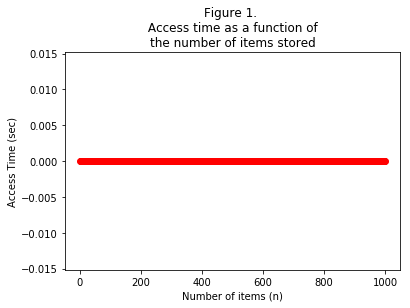

In [7]:
# Import necessary libraries
import time
import matplotlib.pyplot as plt

# Number of items stored
m_items = []
# Access times
all_access_times = []

# Hash functions to be used
hashes_list = []
hashes_list.append(hash_str1)
hashes_list.append(hash_str2)
hashes_list.append(hash_str3)
hashes_list.append(hash_str4)


# Track the access times for the interval m [1,1000]

for m in range(1,1000):
    #Produce a list of random words of size m
    rword_list = randomwords_list(m,11)
    
    # Bloom Filter Table
    bfilter_table = empty_hash_table(1000)
    
    # Insert elements
    for i in range(len(rword_list)):
        add_to_hash_table(bfilter_table, rword_list[i], hashes_list)
        
    # Track access time, by accessing all elements and taking the avg
    start_time = time.time()
    
    total_time = time.time() - start_time
    
    # access_time stands for the time it takes to access any given element
    # under this circumnstances (i.g., m being of a particular size)
    access_time = total_time / m
    
    # Append the information and results of this experiment
    m_items.append(m)
    all_access_times.append(access_time)
        

        
# Time to plot the results.
plt.scatter(m_items,all_access_times,c='r')
# Improve the layout of the graph
plt.title('Figure 1. \n Access time as a function of \nthe number of items stored')
plt.xlabel('Number of items (n)')
plt.ylabel('Access Time (sec)')

plt.show()

This result matches the theoretically expected rate of:

$Access\ Time_{(n)}=O(k)\rightarrow O(1)$

# SOME RANDOM THEORY I'LL GET RID OF LATER

*A Bloom filter with 1% error and an optimal value of k, in contrast, requires only about 9.6 bits per element, regardless of the size of the elements.*

*The 1% false-positive rate can be reduced by a factor of ten by adding only about 4.8 bits per element.*

*To understand its space efficiency, it is instructive to compare the general Bloom filter with its special case when k = 1. If k = 1, then in order to keep the false positive rate sufficiently low, a small fraction of bits should be set, which means the array must be very large and contain long runs of zeros. The information content of the array relative to its size is low. The generalized Bloom filter (k greater than 1) allows many more bits to be set while still maintaining a low false positive rate; if the parameters (k and m) are chosen well, about half of the bits will be set,[5] and these will be apparently random, minimizing redundancy and maximizing information content.*


**Actual numbers...**

*The probability of all of them being 1, which would cause the algorithm to erroneously claim that the element is in the set, is often given as*

$\approx(1-e^{-kn/m})^k$

*This is not strictly correct as it assumes independence for the probabilities of each bit being set. However, assuming it is a close approximation we have that the probability of false positives decreases as m (the number of bits in the array) increases, and increases as n (the number of inserted elements) increases.*




**Actually, what I was looking for is**

*This means that for a given false positive probability p, the length of a Bloom filter m is proportionate to the number of elements being filtered n and the required number of hash functions only depends on the target false positive probability p.[8]*



